## Cogs 127 Case Study Datasci User Research

#### This document houses our analysis of the reviews left on the Figma iOS App (from the Apple App Store reviews)

## Research Question

#### What are the current main complaints or pain points that users have for the touchscreen version of Figma?
 - What specific features are absent, unintuitive, or otherwise unpopular?
 - Do any reviews mention using a stylus (and any associated issues)?


In [33]:
from app_store_scraper import AppStore
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
import re
import string

# nltk.download('stopwords')

# https://pypi.org/project/app-store-scraper/ <- very good library, glad to not write bs4 code for all of it
# 1152747299 - figma apple app store id

# limits of this document: I only have english language skills, so I'm limiting it to a subset of countries that
# mainly speak English. This sample is not representative of the entire market or userbase, but for a design
# case study, I think a few hundred reviews is enough to find user issues.

def get_appstore_object(country, app_name, app_id):
    app = AppStore(country, app_name, app_id)
    app.review()

    print(f'{app_name} review count in {country}: {app.reviews_count}')
    
    return app


# https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2 <- library uses these ISO codes
primarily_english_speaking_countries = ['us', 'ca', 'gb', 'au', 'ie', 'nz']

FIGMA_APP_NAME = 'figma'
FIGMA_APP_ID = '1152747299'

figma_apps_by_country = {}

for country in primarily_english_speaking_countries:
    figma_apps_by_country[country] = get_appstore_object(country, FIGMA_APP_NAME, FIGMA_APP_ID)
    
print(figma_apps_by_country)


2023-02-05 19:45:38,161 [INFO] Base - Initialised: AppStore('us', 'figma', 1152747299)
2023-02-05 19:45:38,163 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/figma/id1152747299
2023-02-05 19:45:39,704 [INFO] Base - [id:1152747299] Fetched 201 reviews (201 fetched in total)


figma review count in us: 201


2023-02-05 19:45:40,420 [INFO] Base - Initialised: AppStore('ca', 'figma', 1152747299)
2023-02-05 19:45:40,421 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/ca/app/figma/id1152747299
2023-02-05 19:45:40,682 [INFO] Base - [id:1152747299] Fetched 33 reviews (33 fetched in total)


figma review count in ca: 33


2023-02-05 19:45:41,076 [INFO] Base - Initialised: AppStore('gb', 'figma', 1152747299)
2023-02-05 19:45:41,078 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/figma/id1152747299
2023-02-05 19:45:41,619 [INFO] Base - [id:1152747299] Fetched 41 reviews (41 fetched in total)


figma review count in gb: 41


2023-02-05 19:45:42,105 [INFO] Base - Initialised: AppStore('au', 'figma', 1152747299)
2023-02-05 19:45:42,107 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/au/app/figma/id1152747299
2023-02-05 19:45:42,199 [INFO] Base - [id:1152747299] Fetched 19 reviews (19 fetched in total)


figma review count in au: 19


2023-02-05 19:45:59,360 [INFO] Base - Initialised: AppStore('ie', 'figma', 1152747299)
2023-02-05 19:45:59,362 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/ie/app/figma/id1152747299
2023-02-05 19:45:59,549 [INFO] Base - [id:1152747299] Fetched 1 reviews (1 fetched in total)


figma review count in ie: 1


2023-02-05 19:46:00,116 [INFO] Base - Initialised: AppStore('nz', 'figma', 1152747299)
2023-02-05 19:46:00,117 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/nz/app/figma/id1152747299
2023-02-05 19:46:00,204 [INFO] Base - [id:1152747299] Fetched 5 reviews (5 fetched in total)


figma review count in nz: 5
{'us': AppStore(country='us', app_name='figma', app_id=1152747299), 'ca': AppStore(country='ca', app_name='figma', app_id=1152747299), 'gb': AppStore(country='gb', app_name='figma', app_id=1152747299), 'au': AppStore(country='au', app_name='figma', app_id=1152747299), 'ie': AppStore(country='ie', app_name='figma', app_id=1152747299), 'nz': AppStore(country='nz', app_name='figma', app_id=1152747299)}


In [34]:
print(figma_apps_by_country['us'].reviews[0]) # sanity check

{'date': datetime.datetime(2022, 3, 22, 15, 47, 30), 'review': 'I could really use a few things:\n- Better Apple Pencil support in figjam (real palm rejection; allowing me to write inside of a blob (shape) with my Apple Pencil and convert it to text.)\n- Let me move the toolbox out of the way on the screen.\nFor the preceding improvements I would be willing to pay 2 stars.', 'rating': 5, 'isEdited': False, 'title': 'Making progress', 'userName': 'McNruiser'}


In [35]:
# would like to put the country inside of each review, so we need to wrangle some data

reviews = []
for country in figma_apps_by_country:
    for review in figma_apps_by_country[country].reviews:
        reviews.append([
            review['date'],
            review['review'],
            review['rating'],
            review['isEdited'],
            review['userName'],
            review['title'],
            country
        ])

columns = [
    'date',
    'review_text',
    'rating_score',
    'is_edited',
    'username',
    'title_text',
    'country',
    ]
        
df = pd.DataFrame(columns=columns, data=reviews)

# always backup in case I mess up
df.to_csv('reviews.csv')
df_backup = df

df.head()

,date,review_text,rating_score,is_edited,username,title_text,country
0,2022-03-22 15:47:30,I could really use a few things:\n- Better App...,5,False,McNruiser,Making progress,us
1,2022-09-19 15:11:09,Converted to figma from sketch. Program is a n...,2,False,ADiddle2646,Major design flaw,us
2,2022-07-31 14:58:45,I love Figma on desktop but the mobile app on ...,2,False,Liquidfire37,Buggy and lacks essential features,us
3,2022-10-26 15:48:21,I’m not entirely sure who the audience is for ...,3,False,Park's Pop,A bit flaky,us
4,2023-01-15 07:06:46,This is just a comment on Figma as a company. ...,1,False,gonobeanoe,Figma Dark Patterns,us


In [36]:
# data cleaning
df = df_backup # always start with fresh copy for this cell


# library returns newlines, we can just switch to spaces
df['review_text'] = df['review_text'].str.replace('\n', ' ').str.lower()
df['title_text'] = df['title_text'].str.replace('\n', ' ').str.lower()

    
if len(df['username'].unique()) != df.shape[0]:
    print('Some duplicate reviews!')


df.head(5)

,date,review_text,rating_score,is_edited,username,title_text,country
0,2022-03-22 15:47:30,i could really use a few things: - better appl...,5,False,McNruiser,making progress,us
1,2022-09-19 15:11:09,converted to figma from sketch. program is a n...,2,False,ADiddle2646,major design flaw,us
2,2022-07-31 14:58:45,i love figma on desktop but the mobile app on ...,2,False,Liquidfire37,buggy and lacks essential features,us
3,2022-10-26 15:48:21,i’m not entirely sure who the audience is for ...,3,False,Park's Pop,a bit flaky,us
4,2023-01-15 07:06:46,this is just a comment on figma as a company. ...,1,False,gonobeanoe,figma dark patterns,us


In [37]:
df['review_text_no_punctuation'] = df['review_text'].str.replace('[^\w\s]','')
df['title_text_no_punctuation'] = df['title_text'].str.replace('[^\w\s]','')

df_backup = df
df.head(5)


/tmp/ipykernel_30232/1034315362.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text_no_punctuation'] = df['review_text'].str.replace('[^\w\s]','')
/tmp/ipykernel_30232/1034315362.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title_text_no_punctuation'] = df['title_text'].str.replace('[^\w\s]','')


,date,review_text,rating_score,is_edited,username,title_text,country,review_text_no_punctuation,title_text_no_punctuation
0,2022-03-22 15:47:30,i could really use a few things: - better appl...,5,False,McNruiser,making progress,us,i could really use a few things better apple ...,making progress
1,2022-09-19 15:11:09,converted to figma from sketch. program is a n...,2,False,ADiddle2646,major design flaw,us,converted to figma from sketch program is a ni...,major design flaw
2,2022-07-31 14:58:45,i love figma on desktop but the mobile app on ...,2,False,Liquidfire37,buggy and lacks essential features,us,i love figma on desktop but the mobile app on ...,buggy and lacks essential features
3,2022-10-26 15:48:21,i’m not entirely sure who the audience is for ...,3,False,Park's Pop,a bit flaky,us,im not entirely sure who the audience is for t...,a bit flaky
4,2023-01-15 07:06:46,this is just a comment on figma as a company. ...,1,False,gonobeanoe,figma dark patterns,us,this is just a comment on figma as a company b...,figma dark patterns


In [38]:
df = df_backup
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
# tokenize game_name and game_blurb, then put the respective results under name_token and blurb_token
df['review_token'] = df['review_text_no_punctuation'].apply(word_tokenize)
df['title_token'] = df['title_text_no_punctuation'].apply(word_tokenize)

df.head(5)

,date,review_text,rating_score,is_edited,username,title_text,country,review_text_no_punctuation,title_text_no_punctuation,review_token,title_token
0,2022-03-22 15:47:30,i could really use a few things: - better appl...,5,False,McNruiser,making progress,us,i could really use a few things better apple ...,making progress,"[i, could, really, use, a, few, things, better...","[making, progress]"
1,2022-09-19 15:11:09,converted to figma from sketch. program is a n...,2,False,ADiddle2646,major design flaw,us,converted to figma from sketch program is a ni...,major design flaw,"[converted, to, figma, from, sketch, program, ...","[major, design, flaw]"
2,2022-07-31 14:58:45,i love figma on desktop but the mobile app on ...,2,False,Liquidfire37,buggy and lacks essential features,us,i love figma on desktop but the mobile app on ...,buggy and lacks essential features,"[i, love, figma, on, desktop, but, the, mobile...","[buggy, and, lacks, essential, features]"
3,2022-10-26 15:48:21,i’m not entirely sure who the audience is for ...,3,False,Park's Pop,a bit flaky,us,im not entirely sure who the audience is for t...,a bit flaky,"[im, not, entirely, sure, who, the, audience, ...","[a, bit, flaky]"
4,2023-01-15 07:06:46,this is just a comment on figma as a company. ...,1,False,gonobeanoe,figma dark patterns,us,this is just a comment on figma as a company b...,figma dark patterns,"[this, is, just, a, comment, on, figma, as, a,...","[figma, dark, patterns]"


In [39]:
df = df_backup
df['title_stop'] = df['title_token'].apply(lambda x: [word for word in x if word not in stop_words])
df['review_stop'] = df['review_token'].apply(lambda x: [word for word in x if word not in stop_words])


df['title_cleaned'] = df['title_stop'].apply(lambda x: [ps.stem(word) for word in x])
df['review_cleaned'] = df['review_stop'].apply(lambda x: [ps.stem(word) for word in x])

columns_to_drop = [ 'date', 
                   'is_edited', 
                   'username', 
                   'review_text_no_punctuation', 
                   'title_text_no_punctuation', 
                   'title_stop', 
                   'review_stop',
                   'review_token',
                   'title_token'
                  ]

df = df.drop(columns=columns_to_drop)
df.head(5)

,review_text,rating_score,title_text,country,title_cleaned,review_cleaned
0,i could really use a few things: - better appl...,5,making progress,us,"[make, progress]","[could, realli, use, thing, better, appl, penc..."
1,converted to figma from sketch. program is a n...,2,major design flaw,us,"[major, design, flaw]","[convert, figma, sketch, program, nice, upgrad..."
2,i love figma on desktop but the mobile app on ...,2,buggy and lacks essential features,us,"[buggi, lack, essenti, featur]","[love, figma, desktop, mobil, app, phone, ipad..."
3,i’m not entirely sure who the audience is for ...,3,a bit flaky,us,"[bit, flaki]","[im, entir, sure, audienc, use, way, keep, tra..."
4,this is just a comment on figma as a company. ...,1,figma dark patterns,us,"[figma, dark, pattern]","[comment, figma, compani, model, shadi, clear,..."


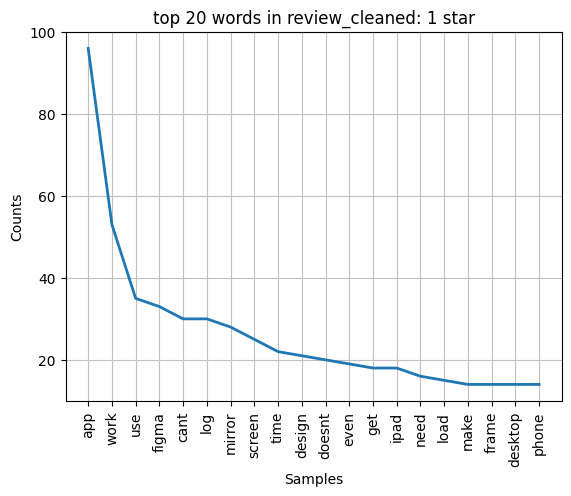

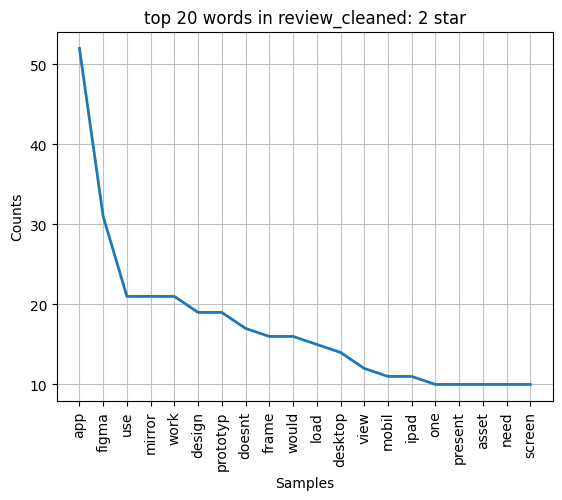

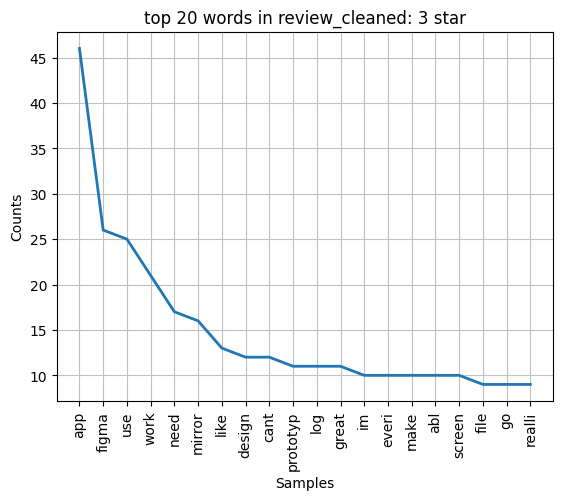

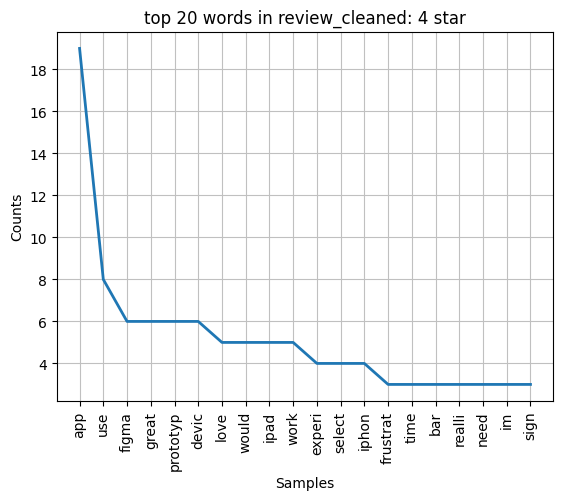

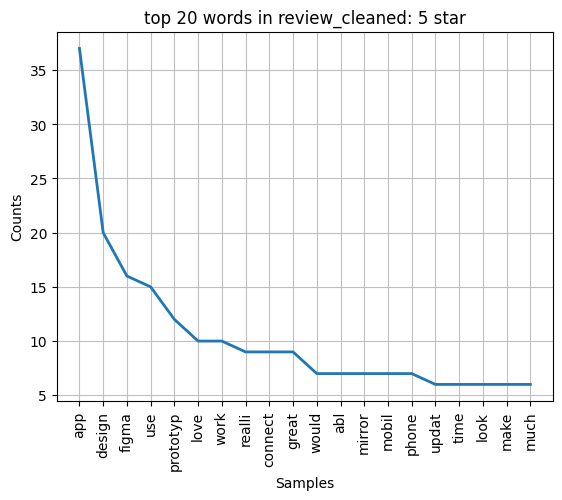

AttributeError: 'Series' object has no attribute 'stack'

In [49]:
df_backup = df


def show_common_words_for_rating_score(num_words, rating_score, text_field, df):
    df_subset = df[df['rating_score'] == rating_score] 
    words = df_subset[text_field].apply(pd.Series).stack()
    words_freq = FreqDist(words)
    graph_title = f'top {num_words} words in {text_field}: {rating_score} star'
    words_freq.plot(num_words, title=graph_title)

num_words = 20
    
for score in range(1, 6):
    show_common_words_for_rating_score(num_words, score, 'review_cleaned', df)
show_common_words_for_rating_score(10, 0, 'review_cleaned', df)